In [91]:
SEED = 42
PYTORCH_PRETRAINED_BERT_CACHE = "/home/sarmishta/.pytorch_pretrained_bert"

In [92]:
import logging
import datetime

import json
import os
import gc
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert import BertAdam
from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear, SCHEDULES
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib notebook

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [5]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs/{}'.format(str(datetime.datetime.now())))

## Plotting function

In [6]:
def plotter(datas, labels=['score']):
    fig = plt.figure(figsize=(9, 6))
    plots = list(datas)
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    
    for i, (data,label) in enumerate(zip(datas, labels)):
        plots[i] = plt.hist(data, color=colors[(i%len(colors))],label=label, bins=10)
    
    plt.legend(loc='best')
    plt.title('Plotted data')
    plt.show()

## Data Preparation

In [48]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()
data_path = 'dataset-sts/data/sts/semeval-sts/all/'
files = os.listdir(data_path)
for file in files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path, sep = '\t', header = None, 
                     names = ['score', 'title', 'desc'], 
                     dtype={'score':np.float64, 'title':str, 'desc':str})    
    if ('train' in file) or ('val' in file):
        df_val = pd.concat([df_val, df])
        print("VALIDATION FILE: "+file)
    else:
        df_test = pd.concat([df_test, df])
        print("TESTING FILE: "+file)

TESTING FILE: 2013.headlines.test.tsv
VALIDATION FILE: 2015.val.tsv
TESTING FILE: 2015.test.tsv
TESTING FILE: 2012.OnWN.test.tsv
TESTING FILE: 2016.answer-answer.test.tsv
TESTING FILE: 2012.MSRpar.test.tsv
TESTING FILE: 2012.SMTeuroparl.test.tsv
TESTING FILE: 2016.plagiarism.test.tsv
TESTING FILE: 2015.belief.test.tsv
VALIDATION FILE: 2012.MSRpar.train.tsv
TESTING FILE: 2014.images.test.tsv
TESTING FILE: 2015.answers-forums.test.tsv
TESTING FILE: 2013.OnWN.test.tsv
TESTING FILE: 2016.question-question.test.tsv
TESTING FILE: 2015.headlines.test.tsv
TESTING FILE: 2015.answers-students.test.tsv
TESTING FILE: 2014.deft-forum.test.tsv
VALIDATION FILE: 2012.SMTeuroparl.train.tsv
TESTING FILE: 2014.OnWN.test.tsv
VALIDATION FILE: 2015.train.tsv
TESTING FILE: 2014.headlines.test.tsv
TESTING FILE: 2013.FNWN.test.tsv
TESTING FILE: 2014.deft-news.test.tsv
TESTING FILE: 2014.tweet-news.test.tsv
TESTING FILE: 2016.headlines.test.tsv
TESTING FILE: 2016.postediting.test.tsv
TESTING FILE: 2015.images.t

In [49]:
len(df_train), len(df_test), len(df_val)

(0, 37098, 5230)

In [50]:
df_train = df_test.dropna()
df_test = df_test[df_test.score.isnull()]

In [51]:
len(df_test)+len(df_train)

37089

In [11]:
df_train.head(), df_test.head(), df_val.head()

(   score                                              title  \
 0    2.6            Drug lord captured by marines in Mexico   
 1    4.4  SC dismisses govt's review plea in Vodafone ta...   
 2    2.6        Explosion hits oil pipeline in Syria's Homs   
 3    3.8               NATO Soldier Killed In Afghan Attack   
 4    4.2             Castro celebrates 86th birthday Monday   
 
                                                 desc  
 0  Suspected drug lord known as ‘El Taliban’ held...  
 1  SC dismisses govt's review petition on Vodafon...  
 2    Explosion hits pipeline as Assad attacks cities  
 3              NATO soldier killed in S. Afghanistan  
 4              Fidel Castro celebrates 86th birthday  ,
    score                                              title  \
 1    NaN  You should check the conditions of your journa...   
 2    NaN  It is not completely true that failures are no...   
 3    NaN  I started one with that goal in mind back in h...   
 5    NaN  Citing onl

In [12]:
df_train.title.str.len().describe(), df_test.title.str.len().describe()

(count    18436.000000
 mean        58.815958
 std         34.476025
 min          3.000000
 25%         38.000000
 50%         49.000000
 75%         68.000000
 max        987.000000
 Name: title, dtype: float64, count    18653.000000
 mean        72.537930
 std         61.565948
 min          6.000000
 25%         44.000000
 50%         61.000000
 75%         87.000000
 max       2718.000000
 Name: title, dtype: float64)

In [13]:
df_train.desc.str.len().describe(), df_test.desc.str.len().describe()

(count    18436.000000
 mean        57.002061
 std         64.731020
 min          7.000000
 25%         38.000000
 50%         49.000000
 75%         65.000000
 max       5290.000000
 Name: desc, dtype: float64, count    18573.000000
 mean        72.588219
 std         67.683759
 min          6.000000
 25%         44.000000
 50%         61.000000
 75%         86.000000
 max       2785.000000
 Name: desc, dtype: float64)

In [14]:
df_train.head()

,score,title,desc
0,2.6,Drug lord captured by marines in Mexico,Suspected drug lord known as ‘El Taliban’ held...
1,4.4,SC dismisses govt's review plea in Vodafone ta...,SC dismisses govt's review petition on Vodafon...
2,2.6,Explosion hits oil pipeline in Syria's Homs,Explosion hits pipeline as Assad attacks cities
3,3.8,NATO Soldier Killed In Afghan Attack,NATO soldier killed in S. Afghanistan
4,4.2,Castro celebrates 86th birthday Monday,Fidel Castro celebrates 86th birthday


In [15]:
print(df_train.shape[0], df_train[df_train.desc.str.len() >= 10].shape[0], df_train[df_train.desc.str.len() > 200].shape[0])

18436 18418 77


In [16]:
df_train = df_train[df_train.desc.str.len() >= 10].copy()

## Preprocessing

In [17]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

In [18]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [57]:
def convert_sentence_pair(score, titles, descs, max_seq_length, tokenizer):
    features = []
    sum = 0
    for (ex_index, (score, title, desc)) in enumerate(zip(score, titles, descs)):
        tokens_a = tokenizer.tokenize(title)

        tokens_b = None
        tokens_b = tokenizer.tokenize(str(desc))
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        if(len(tokens_b) > max_seq_length-3):
            sum +=1
        elif(len(tokens_a) > max_seq_length-3):
            sum +=1
            
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=score/5.0
        ))
    print(sum)
    return features

In [20]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True, 
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE)

03/17/2019 21:25:47 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/sarmishta/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [21]:
correct_pairs = convert_sentence_pair(df_train.score.tolist(), df_train.title.tolist(), df_train.desc.tolist(), max_seq_length=64, tokenizer=tokenizer)

03/17/2019 21:25:47 - INFO - bert -   *** Example ***
03/17/2019 21:25:47 - INFO - bert -   tokens: [CLS] drug lord captured by marines in mexico [SEP] suspected drug lord known as ‘ el taliban ’ held in mexico [SEP]
03/17/2019 21:25:47 - INFO - bert -   input_ids: 101 4319 2935 4110 2011 9622 1999 3290 102 6878 4319 2935 2124 2004 1520 3449 16597 1521 2218 1999 3290 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/17/2019 21:25:47 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/17/2019 21:25:47 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/17/2019 21:25:47 - INFO - bert -   *** Example ***
03/17/2019 21:25:47 - INFO - bert -   tokens: [CLS] sc dismiss ##es govt ' s review plea in vo ##da ##fo ##ne tax case [SEP] sc dis

48


only 10 sentences in the full dataset with more than 125 tokens. 

only 48 sentences in the full dataset with more than 61 tokens. 

In [22]:
len(correct_pairs)

18418

## Model

In [23]:
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased",
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE
).to(device)

03/17/2019 21:25:56 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/sarmishta/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
03/17/2019 21:25:56 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/sarmishta/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpqji_ezyh
03/17/2019 21:25:59 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_siz

## Training

In [24]:
BATCH_SIZE = 32
logger.info("***** Running fine-tuning *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
all_targets = torch.tensor([f.target for f in correct_pairs], dtype=torch.float)

train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_targets)
# Run prediction for full data
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 1.8e-3},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
learning_rate=0.000001
optimizer = BertAdam(optimizer_grouped_parameters, lr=learning_rate)

model.train()

losses = []
num_epochs=6

writer.add_text(
    str(datetime.datetime.now()), 
    "num epochs {}, Loss:log(cosh(x)), lr={}".format(num_epochs, learning_rate)
)

mb = train_dataloader
for epoch in range(num_epochs):
#     before = [param.clone().cpu() for param in list(model.parameters())]
    i = 0
    for input_ids, input_mask, segment_ids, targets in tqdm(mb):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        
        result = nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0]
        loss = torch.sum(torch.log(torch.cosh(targets.to(device)-result)))
#         loss = nn.functional.mse_loss(result, targets.to(device))
        niter = epoch*len(train_dataloader)+i
        writer.add_scalar('Train/Loss', loss, niter)
        losses.append(float(loss.cpu()))
        loss.backward()
        optimizer.step()
        i+=1
#     after = [param.clone().cpu() for param in list(model.parameters())]
#     for i in range(len(before)):
#         assert(not torch.equal(before[i].data, after[i].data))
#         print(before[i].data - after[i].data)

03/17/2019 21:26:04 - INFO - bert -   ***** Running fine-tuning *****
03/17/2019 21:26:04 - INFO - bert -     Num examples = 18418
03/17/2019 21:26:04 - INFO - bert -     Batch size = 32


<IPython.core.display.Javascript object>


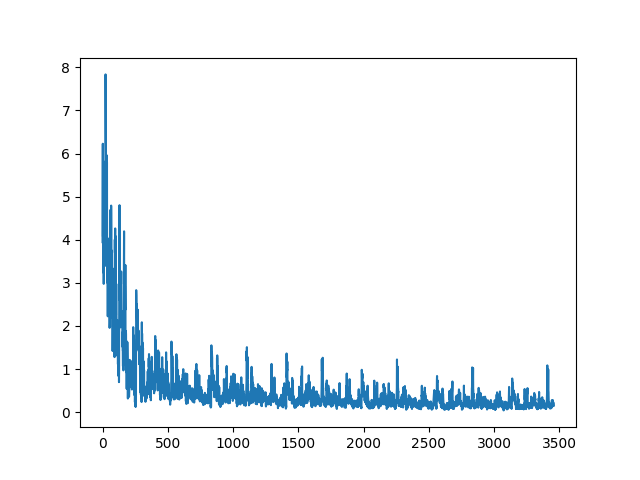

In [93]:
plt.plot(range(len(losses)), losses)

In [26]:
diffs = np.asarray(losses[0:int(len(losses)/2-1)]) - np.asarray(losses[int(len(losses)/2):-1])

In [27]:
diffs.min(), diffs.max()

(-0.09888123720884323, 7.675828456878662)

## Eval Correct Pairs

In [58]:
correct_pairs = convert_sentence_pair(df_val.score.tolist(), df_val.title.tolist(), df_val.desc.tolist(), max_seq_length=128, tokenizer=tokenizer)

03/17/2019 23:23:57 - INFO - bert -   *** Example ***
03/17/2019 23:23:57 - INFO - bert -   tokens: [CLS] global online # education is a key to democrat ##izing access to learning and overcoming societal ill ##s such as poverty - [SEP] op - ed columnist : revolution hits the universities [SEP]
03/17/2019 23:23:57 - INFO - bert -   input_ids: 101 3795 3784 1001 2495 2003 1037 3145 2000 7672 6026 3229 2000 4083 1998 27363 23382 5665 2015 2107 2004 5635 1011 102 6728 1011 3968 13317 1024 4329 4978 1996 5534 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/17/2019 23:23:57 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0


In [59]:
df_val.score.dtype

dtype('float64')

In [60]:
len(correct_pairs)

5230

In [61]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

03/17/2019 23:24:05 - INFO - bert -   ***** Running evaluation *****
03/17/2019 23:24:05 - INFO - bert -     Num examples = 5230
03/17/2019 23:24:05 - INFO - bert -     Batch size = 128


In [62]:
df_val.iloc[0]

score                                                  0.6
title    Global online #education is a key to democrati...
desc     Op-Ed Columnist: Revolution Hits the Universities
Name: 0, dtype: object

<IPython.core.display.Javascript object>


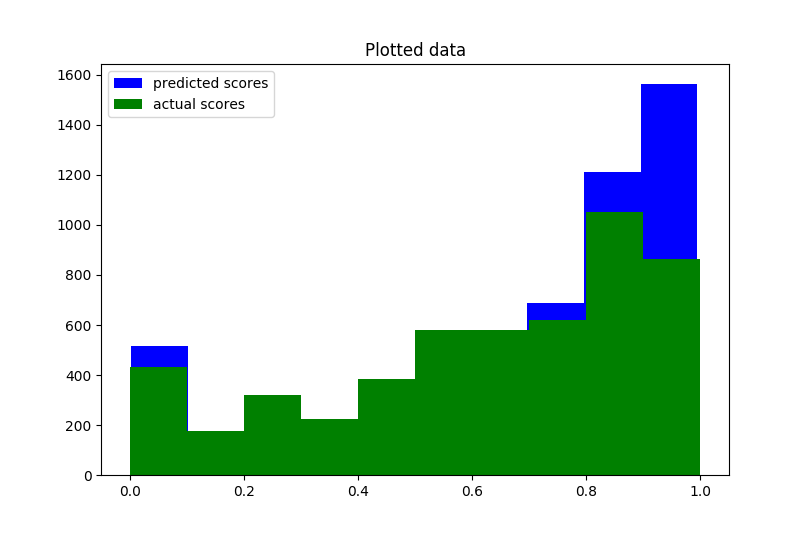

In [98]:
plotter([res, df_val.score/5.0], ['predicted scores', 'actual scores', ])

<IPython.core.display.Javascript object>


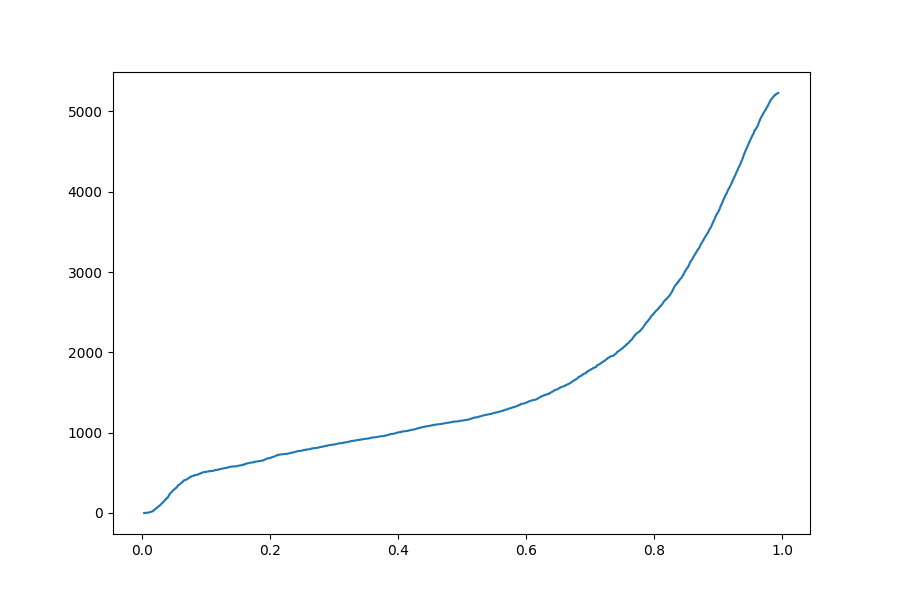

In [101]:
fig = plt.figure(figsize=(9, 6))
plt.plot(sorted(res), range(len(res)))

In [76]:
sum(res > 0.99) / len(res), sum(res > 0.9) / len(res), sum(res < 0.5) / len(res)

(0.0034416826003824093, 0.28336520076481836, 0.22007648183556405)

In [78]:
np.where((res < 0.8) & (res > 0.5))

(array([   1,    8,    9, ..., 5224, 5225, 5228]),)

In [81]:
np.where(res < 0.5)

(array([   0,    5,    6, ..., 5223, 5226, 5229]),)

In [89]:
idx = 9
df_val.iloc[idx].title, df_val.iloc[idx].desc, df_val.iloc[idx].score/5.0, res[idx]

('Cc  ": At least 90 killed in Brazil nightclub fire "',
 'Hundreds killed in Brazil nightclub fire',
 0.6,
 0.7737357)

## Find similar entries

In [ ]:
idx = 102
sentence_pairs = convert_sentence_pair(
    [df_full.iloc[idx]["title"]] * df_full.shape[0], 
    df_full.desc.tolist(), max_seq_length=200, tokenizer=tokenizer)

In [ ]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

In [ ]:
_ = plt.hist(res, bins=100)

In [ ]:
best_matches = np.argsort(res)[::-1][:10]
best_matches

In [ ]:
from pprint import pprint
for _, row in df_full.iloc[best_matches].iterrows():
    pprint(row.to_dict())